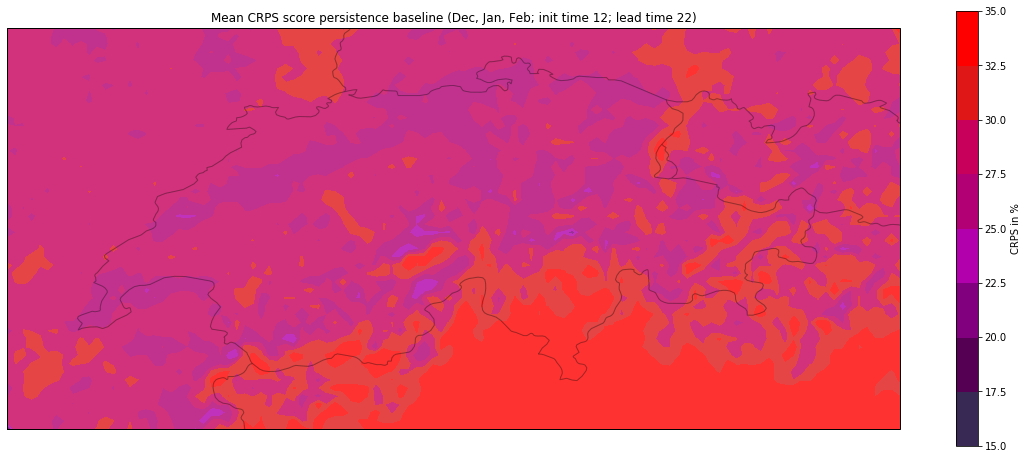

In [16]:
%matplotlib inline

import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.widgets import Slider

filepath = os.path.join("..", "local_playground", "persistence_CRPS_winter_it12_lt22.pkl")
outpath = os.path.join("..", "local_playground", "map_example.png")
time = None  # Set to a pandas Timestamp, or to None to get the mean over all times. 
clim = (15, 35)

## import data
df = pd.read_pickle(filepath).reset_index(["lat", "lon"])
lon = np.unique(df["lon"])
lat = np.unique(df["lat"])
CRPS = df.iloc[(df.time == time).values].CRPS.values.reshape((len(lat), len(lon))) if time else np.transpose(
    df.groupby(["lon", "lat"]).mean().values.reshape((len(lon), len(lat))))
CRPS = np.clip(CRPS, clim[0], clim[1])
CRPS[0, 0] = clim[0]
CRPS[-1, -1] = clim[1]

## make the plot
borders = cft.NaturalEarthFeature("cultural", "admin_0_countries", "10m")
fig = plt.figure(figsize=(20, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([min(lon), max(lon), min(lat), max(lat)])
ax.add_feature(borders, facecolor=(1, 1, 1), alpha=.2, linewidth=1, edgecolor="black")
cs = plt.contourf(lon, lat, CRPS, transform=ccrs.PlateCarree(), 
                  colors=["#372854", "#560054", "#81007d", "#b200ac", "#b20074", "#c8005b", "#df1717", "#ff0000"])
cbar = plt.colorbar(cs)
cbar.ax.set_ylabel("CRPS in %")
# plt.title("CRPS score (" + (time.strftime("%Y.%m.%d %H:%M") if time else "mean") + ", lead time 22)")
plt.title("Mean CRPS score persistence baseline (Dec, Jan, Feb; init time 12; lead time 22)")

# axfreq = plt.axes([0.1, 0.1, 0.65, 0.03], facecolor="yellow")
# sfreq = Slider(axfreq, 'Freq', 0.1, 30.0, valinit=3, valstep=5)

# def update(val):
#     amp = samp.val
#     freq = sfreq.val
# #     l.set_ydata(amp*np.sin(2*np.pi*freq*t))
# #     fig.canvas.draw_idle()
#     print("Update")


# sfreq.on_changed(update)


## save and show the plot
plt.savefig(outpath, dpi=100, format="png")
plt.show()
plt.close(1)

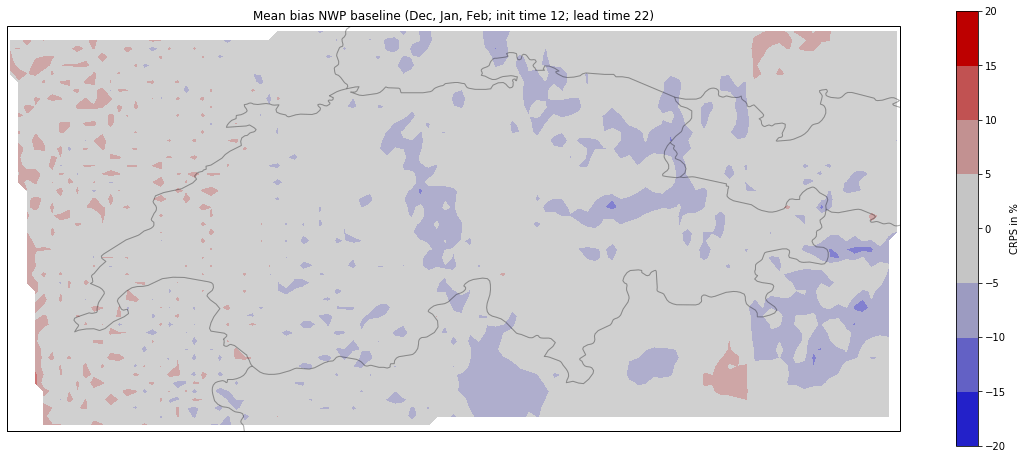

In [1]:
%matplotlib inline

import os
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy.crs as ccrs
import cartopy.feature as cft
import pandas as pd
import numpy as np
import dask.dataframe as dd
from mpl_toolkits.axes_grid1 import make_axes_locatable

filepath = os.path.join("..", "local_playground", "nwp_biases_winter_it12_lt22.pkl")
outpath = os.path.join("..", "local_playground", "map_example.png")
time = None  # Set to a pandas Timestamp, or to None to get the mean over all times. 
clim = (-18, 18)

## import data
df = pd.read_pickle(filepath).reset_index(["lat", "lon"])
# lon_unif = np.linspace(np.min(lon), np.max(lon), 120)
lon_unif = np.array([ 5.525,  5.575,  5.625,  5.675,  5.725,  5.775,  5.825,  5.875,
        5.925,  5.975,  6.025,  6.075,  6.125,  6.175,  6.225,  6.275,
        6.325,  6.375,  6.425,  6.475,  6.525,  6.575,  6.625,  6.675,
        6.725,  6.775,  6.825,  6.875,  6.925,  6.975,  7.025,  7.075,
        7.125,  7.175,  7.225,  7.275,  7.325,  7.375,  7.425,  7.475,
        7.525,  7.575,  7.625,  7.675,  7.725,  7.775,  7.825,  7.875,
        7.925,  7.975,  8.025,  8.075,  8.125,  8.175,  8.225,  8.275,
        8.325,  8.375,  8.425,  8.475,  8.525,  8.575,  8.625,  8.675,
        8.725,  8.775,  8.825,  8.875,  8.925,  8.975,  9.025,  9.075,
        9.125,  9.175,  9.225,  9.275,  9.325,  9.375,  9.425,  9.475,
        9.525,  9.575,  9.625,  9.675,  9.725,  9.775,  9.825,  9.875,
        9.925,  9.975, 10.025, 10.075, 10.125, 10.175, 10.225, 10.275,
       10.325, 10.375, 10.425, 10.475, 10.525, 10.575, 10.625, 10.675,
       10.725, 10.775, 10.825, 10.875, 10.925, 10.975])
lon = df["lon"][0:21240]
# lat_unif = np.linspace(np.min(lat), np.max(lat), 177)
lat_unif = np.array([45.525, 45.575, 45.625, 45.675, 45.725, 45.775, 45.825, 45.875,
       45.925, 45.975, 46.025, 46.075, 46.125, 46.175, 46.225, 46.275,
       46.325, 46.375, 46.425, 46.475, 46.525, 46.575, 46.625, 46.675,
       46.725, 46.775, 46.825, 46.875, 46.925, 46.975, 47.025, 47.075,
       47.125, 47.175, 47.225, 47.275, 47.325, 47.375, 47.425, 47.475,
       47.525, 47.575, 47.625, 47.675, 47.725, 47.775, 47.825, 47.875,
       47.925, 47.975])
lat = df["lat"][0:21240]
# CRPS = df.iloc[(df.time == time).values].CRPS.values.reshape((len(lat), len(lon))) if time else np.transpose(
#     df.groupby(["lon", "lat"]).mean().values.reshape((len(lon), len(lat))))
df = dd.from_pandas(df, npartitions=8)
CRPS = df.groupby(["lon", "lat"]).mean().to_dask_array(lengths=True).reshape((21240,))

triang = tri.Triangulation(lon, lat)
interpolator = tri.LinearTriInterpolator(triang, CRPS)
Lon_unif, Lat_unif = np.meshgrid(lon_unif, lat_unif)
CRPS_unif = interpolator(Lon_unif, Lat_unif)
CRPS_unif = np.clip(CRPS_unif, clim[0], clim[1])
CRPS_unif[0, 0] = clim[0]
CRPS_unif[-1, -1] = clim[1]

## make the plot
borders = cft.NaturalEarthFeature("cultural", "admin_0_countries", "10m")
fig = plt.figure(figsize=(20, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([min(lon), max(lon), min(lat), max(lat)])
ax.add_feature(borders, facecolor=(1, 1, 1), alpha=.2, linewidth=1, edgecolor="black")
cs = plt.contourf(Lon_unif, Lat_unif, CRPS_unif, transform=ccrs.PlateCarree(), 
                  colors=[
                      "#2321c9", "#6361c5", 
                      #"#7d7cc1", 
                      "#9c9bc1", "#c5c5c5", "#c5c5c5", "#c29191", 
                      #"#c07070", 
                      "#c15252","#bd0000"
                  ])
cbar = plt.colorbar(cs)
cbar.ax.set_ylabel("CRPS in %")
# plt.title("CRPS score (" + (time.strftime("%Y.%m.%d %H:%M") if time else "mean") + ", lead time 22)")
plt.title("Mean bias NWP baseline (Dec, Jan, Feb; init time 12; lead time 22)")

## save and show the plot
plt.savefig(outpath, dpi=100, format="png")
plt.show()
plt.close(1)

<IPython.core.display.Javascript object>


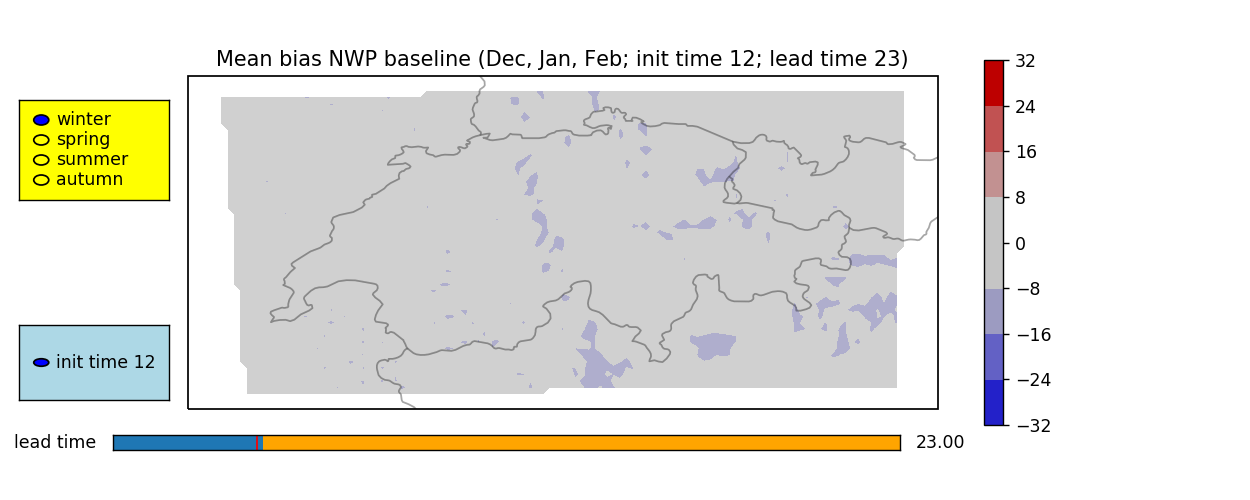

In [4]:
%matplotlib notebook
import os
import pickle
import itertools
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.widgets import Slider, RadioButtons

seasons = ("winter", "spring", "summer", "autumn")
inittimes = ["init time 12"]
leadtimes = range(121)

def two_digits(inittime):
    return inittime[-2:]

filepath = {(season, inittime, leadtime): 
            os.path.join("..", "local_playground", "nwp_biases_" + season + "_it" + two_digits(inittime) + "_lt" + 
                         str(leadtime) + "_mean.pkl") for season, inittime, leadtime in 
            itertools.product(seasons, inittimes, leadtimes)}
months = {"winter": "Dec, Jan, Feb", "spring": "Mar, Apr, May", "summer": "Jun, Jul, Aug", "autumn": "Sep, Oct, Nov"}
clim = (-18, 18)
current_season = "winter"
current_inittime = "init time 12"
current_leadtime = 22

## import data
lon, lat, CRPS = {}, {}, {}
for key in filepath: 
    with open(filepath[key], "rb") as f:
        dic = pickle.load(f)
    lon[key] = dic["lon"]
    lat[key] = dic["lat"]
    CRPSi = dic["CRPS"]
    CRPSi = np.clip(CRPSi, clim[0], clim[1])
    CRPSi[0, 0] = clim[0]
    CRPSi[-1, -1] = clim[1]
    CRPS[key] = CRPSi
    

borders = cft.NaturalEarthFeature("cultural", "admin_0_countries", "10m")
colors = ["#2321c9", "#6361c5", "#9c9bc1", "#c5c5c5", "#c5c5c5", "#c29191", "#c15252","#bd0000"]

def update(key = (current_season, current_inittime, current_leadtime)):
    ax.clear()
    ax.add_feature(borders, facecolor=(1, 1, 1), alpha=.2, linewidth=1, edgecolor="black")
    cs = ax.contourf(lon[key], lat[key], CRPS[key], transform=ccrs.PlateCarree(), colors=colors)
    ax.set_title("Mean bias NWP baseline (" + months[key[0]] + "; " + key[1] + "; lead time " 
                 + str(key[2]) + ")")
    return cs

def update_season(season = current_season):
    global current_season
    current_season = season
    key = (season, current_inittime, current_leadtime)
    return update(key)

def update_inittime(inittime = current_inittime):
    global current_inittime
    current_inittime = inittime
    key = (current_season, inittime, current_leadtime)
    return update(key)

def update_leadtime(leadtime = current_leadtime):
    global current_leadtime
    current_leadtime = int(leadtime)
    key = (current_season, current_inittime, int(leadtime))
    return update(key)


fig = plt.figure(figsize=(10, 4))
plt.subplots_adjust(left=0.15, bottom=0.15)
ax = plt.axes(projection=ccrs.PlateCarree())
cs = update()
cbar = plt.colorbar(cs)

season_ax = plt.axes([0.015, 0.6, 0.12, 0.2], facecolor="yellow")
season_button = RadioButtons(season_ax, seasons, active=0)
inittime_ax = plt.axes([0.015, 0.2, 0.12, 0.15], facecolor="lightblue")
inittime_button = RadioButtons(inittime_ax, inittimes, active=0)
leadtime_ax = plt.axes([0.09, 0.1, 0.63, 0.03], facecolor="orange")
leadtime_slider = Slider(leadtime_ax, "lead time", 0, 120, valinit=22, valstep=1)

season_button.on_clicked(update_season)
inittime_button.on_clicked(update_inittime)
leadtime_slider.on_changed(update_leadtime)
plt.show()

<IPython.core.display.Javascript object>


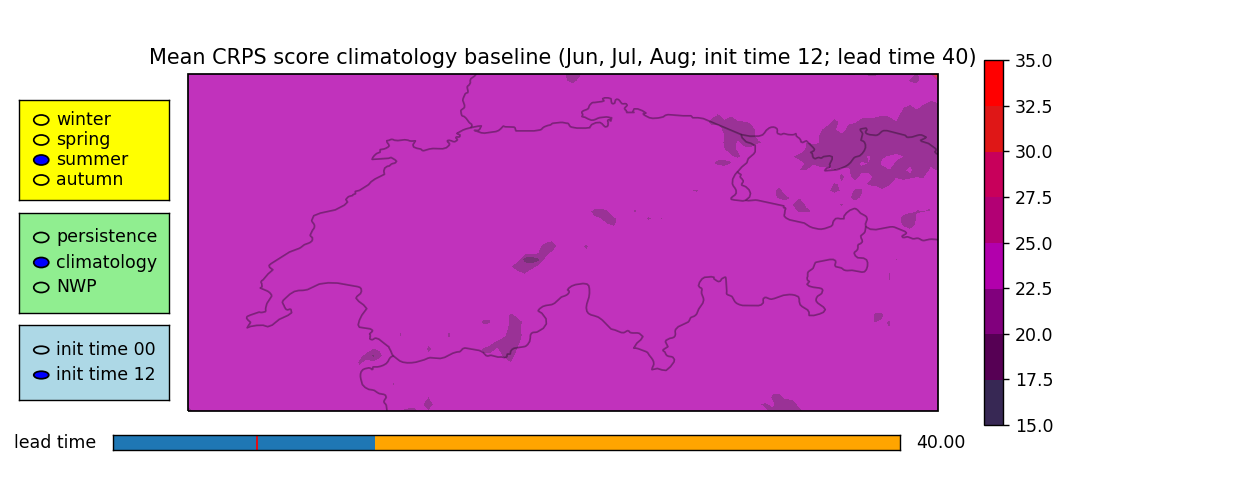

In [1]:
%matplotlib notebook
import os
import pickle
import itertools
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.widgets import Slider, RadioButtons

seasons = ("winter", "spring", "summer", "autumn")
baselines = ("persistence", "climatology", "NWP")
filename_mapper = {"persistence": "persistence_CRPS_", "climatology": "climatology_CRPS_", "NWP": "nwp_crps_scores_"}
inittimes = ("init time 00", "init time 12")
leadtimes = range(121)

def two_digits(inittime):
    return inittime[-2:]

filepath = {(season, baseline, inittime, leadtime): 
            os.path.join("..", "local_playground", filename_mapper[baseline] + season + ("_it" + two_digits(inittime) + "_lt" + 
                         str(leadtime) if not baseline == "climatology" else "_" + str((leadtime + int(two_digits(inittime))) % 24)) + 
                         "_mean.pkl") for season, baseline, inittime, leadtime in itertools.product(seasons, baselines, inittimes, leadtimes)}
months = {"winter": "Dec, Jan, Feb", "spring": "Mar, Apr, May", "summer": "Jun, Jul, Aug", "autumn": "Sep, Oct, Nov"}
clim = (15, 35)
current_season = "winter"
current_baseline = "persistence"
current_inittime = "init time 12"
current_leadtime = 22

## import data
lon, lat, CRPS = {}, {}, {}
for key in filepath: 
    with open(filepath[key], "rb") as f:
        dic = pickle.load(f)
    lon[key] = dic["lon"]
    lat[key] = dic["lat"]
    CRPSi = dic["CRPS"]
    CRPSi = np.clip(CRPSi, clim[0], clim[1])
    CRPSi[0, 0] = clim[0]
    CRPSi[-1, -1] = clim[1]
    CRPS[key] = CRPSi
    

borders = cft.NaturalEarthFeature("cultural", "admin_0_countries", "10m")
colors = ["#372854", "#560054", "#81007d", "#b200ac", "#b20074", "#c8005b", "#df1717", "#ff0000"]

def update(key = (current_season, current_baseline, current_inittime, current_leadtime)):
    ax.clear()
    ax.add_feature(borders, facecolor=(1, 1, 1), alpha=.2, linewidth=1, edgecolor="black")
    cs = ax.contourf(lon[key], lat[key], CRPS[key], transform=ccrs.PlateCarree(), colors=colors)
    ax.set_title("Mean CRPS score " + key[1] + " baseline (" + months[key[0]] + "; " + key[2] + "; lead time " 
                 + str(key[3]) + ")")
    return cs

def update_season(season = current_season):
    global current_season
    current_season = season
    key = (season, current_baseline, current_inittime, current_leadtime)
    return update(key)

def update_baseline(baseline = current_baseline):
    global current_baseline
    current_baseline = baseline
    key = (current_season, baseline, current_inittime, current_leadtime)
    return update(key)

def update_inittime(inittime = current_inittime):
    global current_inittime
    current_inittime = inittime
    key = (current_season, current_baseline, inittime, current_leadtime)
    return update(key)

def update_leadtime(leadtime = current_leadtime):
    global current_leadtime
    current_leadtime = int(leadtime)
    key = (current_season, current_baseline, current_inittime, int(leadtime))
    return update(key)


fig = plt.figure(figsize=(10, 4))
plt.subplots_adjust(left=0.15, bottom=0.15)
ax = plt.axes(projection=ccrs.PlateCarree())
cs = update()
cbar = plt.colorbar(cs)

season_ax = plt.axes([0.015, 0.6, 0.12, 0.2], facecolor="yellow")
season_button = RadioButtons(season_ax, seasons, active=0)
baseline_ax = plt.axes([0.015, 0.375, 0.12, 0.2], facecolor="lightgreen")
baseline_button = RadioButtons(baseline_ax, baselines, active=0)
inittime_ax = plt.axes([0.015, 0.2, 0.12, 0.15], facecolor="lightblue")
inittime_button = RadioButtons(inittime_ax, inittimes, active=1)
leadtime_ax = plt.axes([0.09, 0.1, 0.63, 0.03], facecolor="orange")
leadtime_slider = Slider(leadtime_ax, "lead time", 0, 120, valinit=22, valstep=1)

season_button.on_clicked(update_season)
baseline_button.on_clicked(update_baseline)
inittime_button.on_clicked(update_inittime)
leadtime_slider.on_changed(update_leadtime)
plt.show()